## The dataset used in this analysis was obtained from the New York City Airbnb Open Data collection on Kaggle, originally compiled by Dmitry Gomonov (2019). It contains detailed listing information for Airbnb properties in New York City. The dataset was accessed via Kaggle at:
## https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

## STEP 1: Imports + Data Loading (Done by Saniya Shaikh)

In [ ]:
# ==============================
# 1. IMPORT LIBRARIES
# ==============================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors

In [4]:
# ==============================
# 2. LOAD DATA
# ==============================

df = pd.read_csv(r"C:\Users\saniy\Downloads\-Airbnb-NYC-Price-Prediction-Neighborhood-Clustering-A-Machine-Learning-Analysis-\Data\AB_NYC_2019.csv")
print(df.shape)
df.head()


(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## STEP 2: Basic Data Inspection (Saniya Shaikh)

In [5]:
# ==============================
# 3. BASIC INSPECTION
# ==============================

df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## STEP 3: HANDLE MISSING VALUES (Done by Saniya Shaikh)

In [6]:
# Fill reviews_per_month with 0 where number_of_reviews == 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)


In [7]:
df.drop(columns=['last_review'], inplace=True)


In [8]:
df['name'] = df['name'].fillna("Unknown")
df['host_name'] = df['host_name'].fillna("Unknown")


In [9]:
# ==============================
# CHECKPOINT: DATA AFTER BASIC CLEANING
# ==============================

print("Shape of dataset:", df.shape)

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

df.head()


Shape of dataset: (48895, 15)

Missing values per column:
id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Data types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          objec

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [11]:
# ==============================
# SAVE BASE CLEANED DATASET
# ==============================

df.to_csv("AB_NYC_2019_basic_cleaned.csv", index=False)


## STEP 4: FEATURE ENGINEERING (Done by Saniya Shaikh)

In [14]:
# ==============================
# LOAD BASIC CLEANED DATASET
# ==============================

df = pd.read_csv(r"C:\Users\saniy\Downloads\-Airbnb-NYC-Price-Prediction-Neighborhood-Clustering-A-Machine-Learning-Analysis-\Cleaned_Data\AB_NYC_2019_basic_cleaned.csv")
print(df.shape)
df.head()


(48895, 15)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [15]:
def price_category(price):
    if price < 100:
        return 'Budget'
    elif price <= 200:
        return 'Mid-range'
    else:
        return 'Luxury'

df['price_category'] = df['price'].apply(price_category)


In [16]:
MAN_LAT = 40.7589
MAN_LONG = -73.9851

df['distance_from_manhattan'] = np.sqrt(
    (df['latitude'] - MAN_LAT)**2 +
    (df['longitude'] - MAN_LONG)**2
)


In [17]:
df['price_per_night_ratio'] = df['price'] / df['minimum_nights']


In [18]:
df['host_experience'] = df['calculated_host_listings_count'].apply(
    lambda x: 0 if x == 1 else 1
)


In [19]:
def review_activity(n):
    if n == 0:
        return 'Low'
    elif n <= 50:
        return 'Medium'
    else:
        return 'High'

df['review_activity'] = df['number_of_reviews'].apply(review_activity)


## STEP 5: OUTLIER REMOVAL (RULE-BASED) (Done by Saniya Shaikh)

In [20]:
# Remove price anomalies
df = df[(df['price'] > 0) & (df['price'] <= 1000)]

# Remove unrealistic minimum nights
df = df[df['minimum_nights'] <= 365]

print("Shape after outlier removal:", df.shape)


Shape after outlier removal: (48631, 20)


In [21]:
df = pd.get_dummies(
    df,
    columns=['neighbourhood_group', 'room_type', 'price_category', 'review_activity'],
    drop_first=True
)


In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['neighbourhood_encoded'] = le.fit_transform(df['neighbourhood'])
df.drop(columns=['neighbourhood'], inplace=True)


## STEP 7: FEATURE SCALING (Done by Saniya Shaikh)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scale_cols = [
    'price', 'latitude', 'longitude',
    'number_of_reviews', 'minimum_nights',
    'distance_from_manhattan',
    'price_per_night_ratio'
]

df[scale_cols] = scaler.fit_transform(df[scale_cols])


In [25]:
df.to_csv("AB_NYC_2019_Tranformed.csv", index=False)


## STEP 8 NOISE INJECTION & CLEANING (Done by Saniya Shaikh)

In [27]:
df_clean = pd.read_csv(r"C:\Users\saniy\Downloads\-Airbnb-NYC-Price-Prediction-Neighborhood-Clustering-A-Machine-Learning-Analysis-\Tranformed_Data\AB_NYC_2019_Tranformed.csv")

# Keep a copy for comparison
df_original = df_clean.copy()


### STEP 8.1: ADD GAUSSIAN NOISE TO PRICE

In [28]:
np.random.seed(42)

price_std = df_clean['price'].std()
noise = np.random.normal(0, 0.15 * price_std, size=len(df_clean))

df_noisy = df_clean.copy()
df_noisy['price'] = df_noisy['price'] + noise


### Gaussian noise was added to simulate pricing inconsistencies and recording errors.

### STEP 8.2: ADD GEOGRAPHICAL OUTLIERS (LAT/LONG)

In [29]:
n_outliers = int(0.05 * len(df_noisy))
outlier_indices = np.random.choice(df_noisy.index, n_outliers, replace=False)

df_noisy.loc[outlier_indices, 'latitude'] += np.random.choice([-0.5, 0.5], size=n_outliers)
df_noisy.loc[outlier_indices, 'longitude'] += np.random.choice([-0.5, 0.5], size=n_outliers)


### STEP 8.3: CLEANING — PRICE OUTLIERS (IQR METHOD)

In [30]:
Q1 = df_noisy['price'].quantile(0.25)
Q3 = df_noisy['price'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_denoised = df_noisy[
    (df_noisy['price'] >= lower) &
    (df_noisy['price'] <= upper)
]


### STEP 8.4: WINSORIZATION (CAP EXTREME PRICES)

In [34]:
lower_cap = df_denoised['price'].quantile(0.05)

In [39]:
upper_cap = df_denoised['price'].quantile(0.95)

In [42]:
df_denoised = df[df['price'] > 0].copy()


In [43]:
df_denoised['price'] = df_denoised['price'].clip(lower_cap, upper_cap)


### KNN SMOOTHING FOR LAT/LONG

In [44]:
from sklearn.neighbors import NearestNeighbors

coords = df_denoised[['latitude', 'longitude']].values
nbrs = NearestNeighbors(n_neighbors=5).fit(coords)
_, indices = nbrs.kneighbors(coords)

smoothed_coords = np.array([
    coords[idx].mean(axis=0) for idx in indices
])

df_denoised['latitude'] = smoothed_coords[:, 0]
df_denoised['longitude'] = smoothed_coords[:, 1]


### REQUIRED COMPARISON PLOTS (Done by Saniya Shaikh)

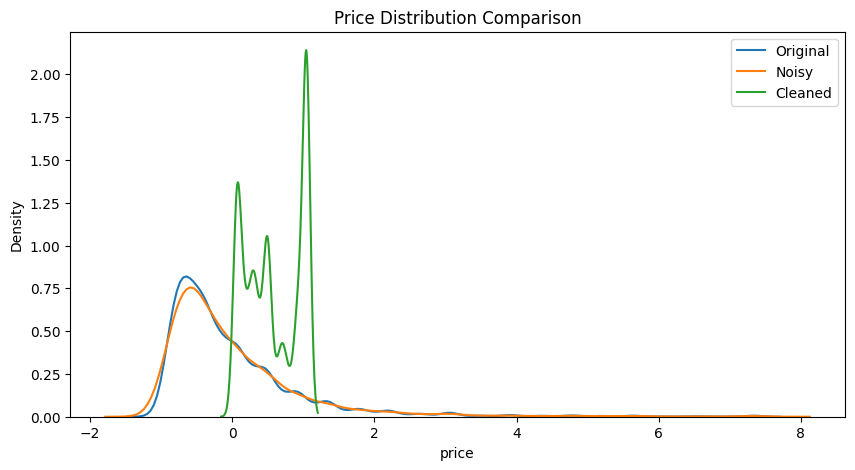

In [45]:
plt.figure(figsize=(10,5))
sns.kdeplot(df_original['price'], label='Original')
sns.kdeplot(df_noisy['price'], label='Noisy')
sns.kdeplot(df_denoised['price'], label='Cleaned')
plt.legend()
plt.title("Price Distribution Comparison")
plt.show()


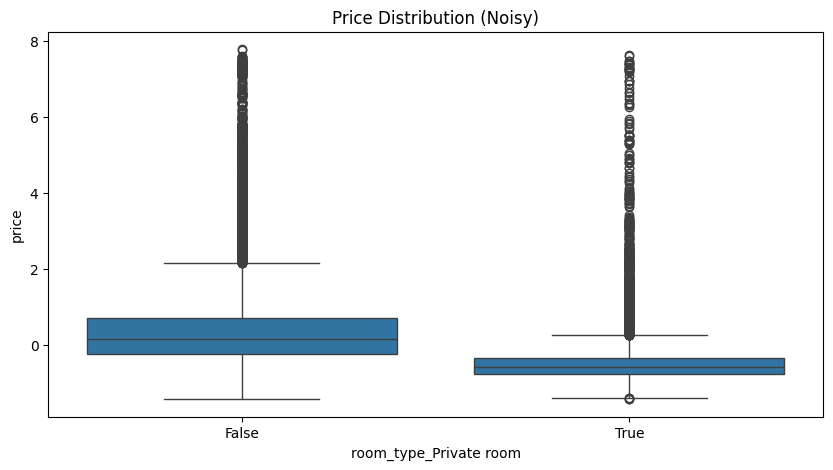

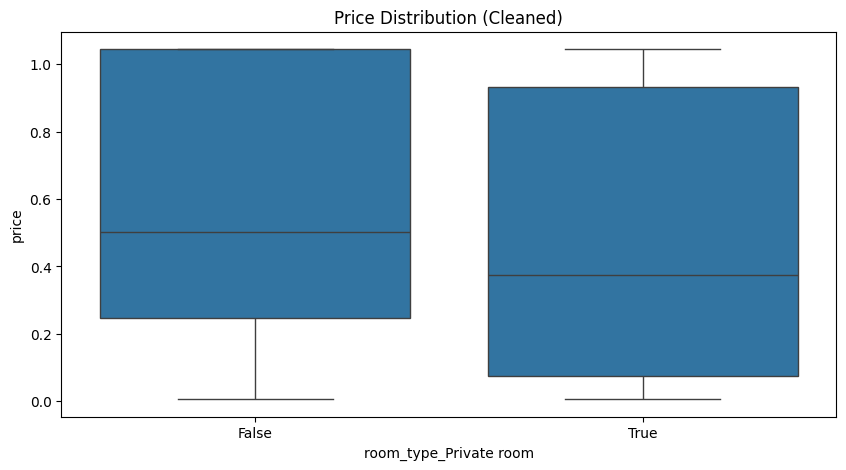

In [46]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_noisy, x='room_type_Private room', y='price')
plt.title("Price Distribution (Noisy)")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df_denoised, x='room_type_Private room', y='price')
plt.title("Price Distribution (Cleaned)")
plt.show()


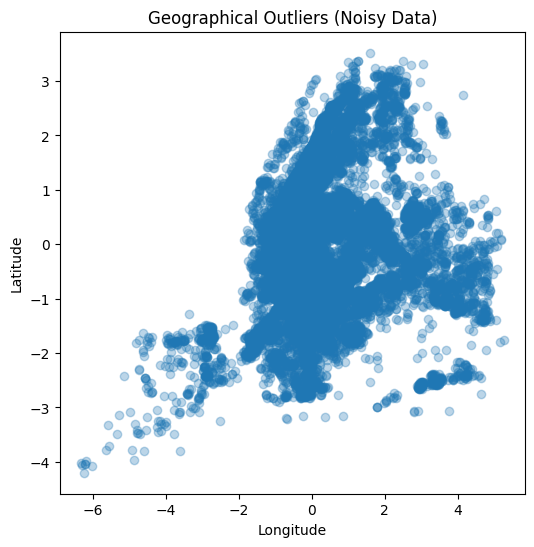

In [47]:
plt.figure(figsize=(6,6))
plt.scatter(df_noisy['longitude'], df_noisy['latitude'], alpha=0.3)
plt.title("Geographical Outliers (Noisy Data)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [48]:
df_denoised.to_csv("AB_NYC_2019_denoised.csv", index=False)
